In [1]:
import config
from forklens import train
from forklens.dataset import ShapeDataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time

A quick test on how the trained CNN measures galaxy shapes and shear. This tutorial should be run after training (./cnn_train.py).

In [2]:
tr = train.Train()
model_file = "./model/test_model149"
model = tr.load_model(path=model_file,strict=True)

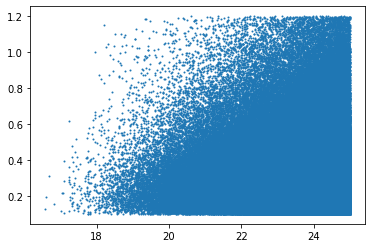

In [3]:
# Load data catalog
with fits.open('../../data/csst_snr_catalog.fits') as f:
    cat = f[0].data
cut_idx = np.where((cat[:,3]>0.1)&(cat[:,4]<25))[0]
size_cat = cat[cut_idx,3]
mag_cat = cat[cut_idx,4]

plt.scatter(mag_cat[::10],size_cat[::10],s=1)
plt.xlabel('mag')
plt.ylabel('hlr')

In [4]:
with fits.open('./model/training_loss.fits') as f:
    train_losses = f[0].data
    valid_losses = f[1].data

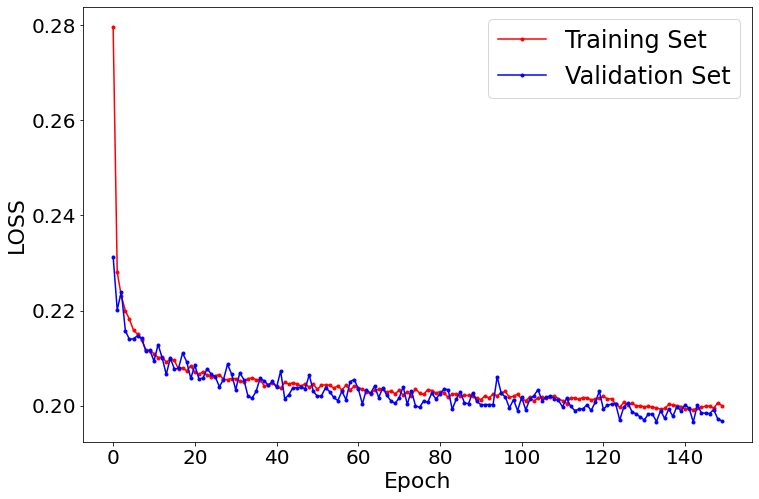

In [5]:
plt.figure(figsize=(12,8))

plt.plot(train_losses, 'r.-', label="Training Set")
plt.plot(valid_losses, 'b.-', label='Validation Set')

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("LOSS", fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.legend(fontsize=24)

## Shape Measurement with CNN

In [6]:
# Generate data
def dataframe(num, seed=12345):
    
    num = int(num/2)
    
    rng1 = np.random.RandomState(seed)
    idx = rng1.randint(0,mag_cat.shape[0],size=num)
    Gal_Hlr   = size_cat[idx]
    Gal_Hlr   = np.concatenate((Gal_Hlr, Gal_Hlr), axis=0)
    Gal_Mag   = mag_cat[idx]
    Gal_Mag   = np.concatenate((Gal_Mag, Gal_Mag), axis=0)
    
    rng2 = np.random.RandomState(seed+1)
    Gal_Theta = rng2.random(num*2)*2*np.pi
    Gal_ELL = np.sqrt(rng2.random(num*2))*0.999
    e1 = Gal_ELL*np.sin(2*Gal_Theta)
    e2 = Gal_ELL*np.cos(2*Gal_Theta)

    rng3 = np.random.RandomState(seed+2)
    PSF_randint = rng3.randint(0,10000,size=num)
    PSF_randint = np.concatenate((PSF_randint, PSF_randint), axis=0)
    
    gal_pars = {}
    gal_pars["e1"] = e1
    gal_pars["e2"] = e2
    gal_pars["hlr_disk"] = Gal_Hlr
    gal_pars["mag_i"] = Gal_Mag
    
    psf_pars = {}
    psf_pars['randint'] = PSF_randint
    
    return gal_pars, psf_pars

In [7]:
# Get data loader
nSims = 5000
GalCat, PSFCat = dataframe(nSims, seed=11111)
test_ds = ShapeDataset(GalCat, PSFCat)
test_dl = DataLoader(test_ds, 
                      batch_size=config.train['batch_size'], 
                      num_workers=config.train['workers'])

pred, true, snr, loss = tr._predictFunc(test_dl,model)
print('Test LOSS:',loss)
diff = pred - true

Test LOSS: 0.1951574749827976


In [8]:
# just for plotting purpose
snr[np.where(snr[:,1]>50),1] = 50

/tmp/ipykernel_3655106/1399946738.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  clb.ax.set_yticklabels([10,20,30,40,'>50']);


<Figure size 576x432 with 0 Axes>

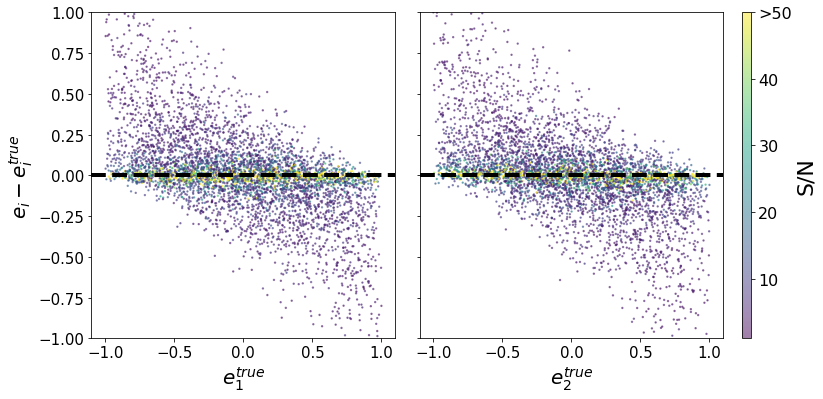

In [9]:
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

axes[0].scatter(true[:,1], diff[:,1], s=2, c=snr[:,1], alpha=0.5)
im = axes[1].scatter(true[:,2], diff[:,2], s=2, c=snr[:,1], alpha=0.5)
axes[0].set_ylim(-1,1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=4)
    
axes[0].set_xlabel(r'$e^{true}_1$',fontsize=20)
axes[1].set_xlabel(r'$e^{true}_2$',fontsize=20)
axes[0].set_ylabel(r'$e_i-e^{true}_i$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.82, 0.125, 0.01, 0.755])
clb = fig1.colorbar(im, cax=cbar_ax)

clb.ax.tick_params(labelsize=16) 
clb.set_label('S/N', fontsize=22)
clb.ax.set_yticklabels([10,20,30,40,'>50']);

## Shear Measurement with CNN

In [10]:
from forklens.dataset import ShearDataset

In [14]:
case_num = 20
real_num = 10000

seed = 20230922
rng = np.random.RandomState(seed)
Gal_Shear   = rng.random((case_num,2))*(-0.1-0.1)+0.1

for i in range(case_num):
    
    sub_seed = seed + i
    rng1 = np.random.RandomState(sub_seed)
    
    idx = rng1.randint(0,mag_cat.shape[0],size=int(real_num))
    Gal_Hlr     = size_cat[idx]
    Gal_Mag     = mag_cat[idx]
    
    rng2 = np.random.RandomState(sub_seed+1)
    Gal_Phi     = rng2.random(size=int(real_num/2))*(-np.pi/2-np.pi/2)+np.pi/2
    Gal_Phi     = np.concatenate((Gal_Phi, Gal_Phi+np.pi/2), axis=0)
    
    rng3 = np.random.RandomState(sub_seed+2)
    Gal_AxRatio = rng.random(size=int(real_num/2))*(0.1-1.)+1.
    Gal_AxRatio = np.concatenate((Gal_AxRatio, Gal_AxRatio), axis=0)
    
    Gal_E1 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.cos(Gal_Phi*2)
    Gal_E2 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.sin(Gal_Phi*2)

    PSF_randint = rng.randint(0,high=10000,size=real_num)
    
    if i == 0:
        gal_pars = {}
        gal_pars["e1"] = Gal_E1
        gal_pars["e2"] = Gal_E2
        gal_pars["hlr_disk"] = Gal_Hlr
        gal_pars["mag_i"] = Gal_Mag
        gal_pars['randint'] = PSF_randint
    else:
        gal_pars["e1"] = np.vstack((gal_pars["e1"], Gal_E1))
        gal_pars["e2"] = np.vstack((gal_pars["e2"], Gal_E2))
        gal_pars["hlr_disk"] = np.vstack((gal_pars["hlr_disk"], Gal_Hlr))
        gal_pars["mag_i"] = np.vstack((gal_pars["mag_i"], Gal_Mag))
        gal_pars['randint'] = np.vstack((gal_pars["randint"], PSF_randint))

shear_pars = {}
shear_pars['shear'] = Gal_Shear

In [15]:
shear_ds = ShearDataset(shear_pars, gal_pars)
shear_dl = DataLoader(shear_ds, 
                      batch_size=config.train['batch_size'], 
                      num_workers=40)

pred, true, snr, _ = tr._predictFunc(shear_dl,model)
diff = pred - true

In [17]:
results = pred[:,1:].reshape(case_num,real_num,4)
g = np.zeros((case_num,2))
for i in range(case_num):
    g[i,0] = np.mean(results[i,:,0])
    g[i,1] = np.mean(results[i,:,1])


coeffs, cov = np.polyfit(shear_pars['shear'][:,0], 
                         g[:,0]-shear_pars['shear'][:,0], 1, cov=True)

# Extract the best-fit values and standard deviations
k, b = coeffs
std_k = np.sqrt(cov[0, 0])
std_b = np.sqrt(cov[1, 1])

# m, m error, c, c error
k,std_k,b,std_b

(-0.249073683681274,
 0.007728483044000791,
 -0.009342311083129672,
 0.0004553513634309142)

Text(0.5, 1.0, 'CNN shear measurement')

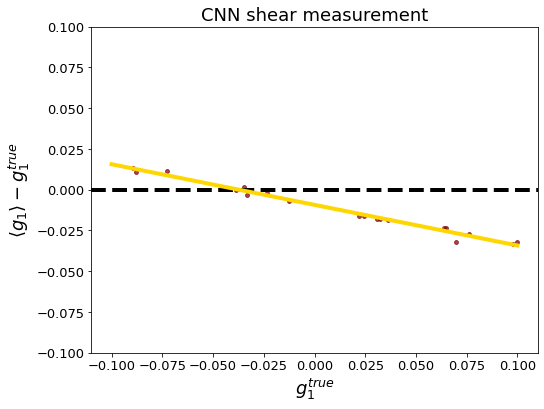

In [18]:
plt.figure(figsize=(8,6))

plt.scatter(shear_pars['shear'][:,0],g[:,0]-shear_pars['shear'][:,0],s=15,color='maroon',alpha=0.7)

plt.axhline(0,color='k',linestyle='--',linewidth=4)
x = np.linspace(-0.1,0.1)
y = k*x+b
plt.plot(x,y,color='gold',linewidth=4)

plt.ylim(-0.1,0.1)
plt.tick_params(axis='both',which='major',labelsize=13)
plt.xlabel(r'$g^{true}_1$',fontsize=18)
plt.ylabel(r'$\left<g_1\right>-g^{true}_1$',fontsize=18)
plt.title('CNN shear measurement', fontsize=18)

The above shear measurement is obviously biased, which can be potentially calibrated with an external calibration algorithm, e.g., Metalibarion (Sheldon et al 2017; Ribli et al 2019) and neural networks (Tewes et al 2018).

The latter we have tested in our work and the code is from http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/621/A36.